# Digital Filter for Signal Processing

This *Jupyter Notebook* is dedicated to the study of the **Digital Filtering Techniques and Intuitions**. 

The following study will be developed by the implementation of *Python* code for the application and visualization of the concepts learned with the use of *NumPy* and *Plotly* libraries. 

The following model is based and adapted from [this article](https://cookierobotics.com/084/).

---

## Filter Intuitions

Filters are used for getting the information you want from signals. Signals, independently from their physical nature, can be understood as a lot of sine waves characterized by their own unique frequency, each with their own respective size (see [Fourier Transform](https://en.wikipedia.org/wiki/Fourier_transform)). The amplitude of each sine wave will tell "how much" of the said frequency is on the signal.

Usually, when you say you're filtering a signal, you're _attenuating_ some of those amplitudes - thus, making some frequencies less perceptible in the output signal. The most common filters are:

- **Low-Pass Filter**: as the name suggests, it lets the low frequencies "pass", "blocking" the high ones;
- **High-Pass Filter**: same as above, but inverted;
- **Band-Pass Filter**: lets just an interval of frequencies "pass";
- **Band-Reject Filter**: inverted band-pass.

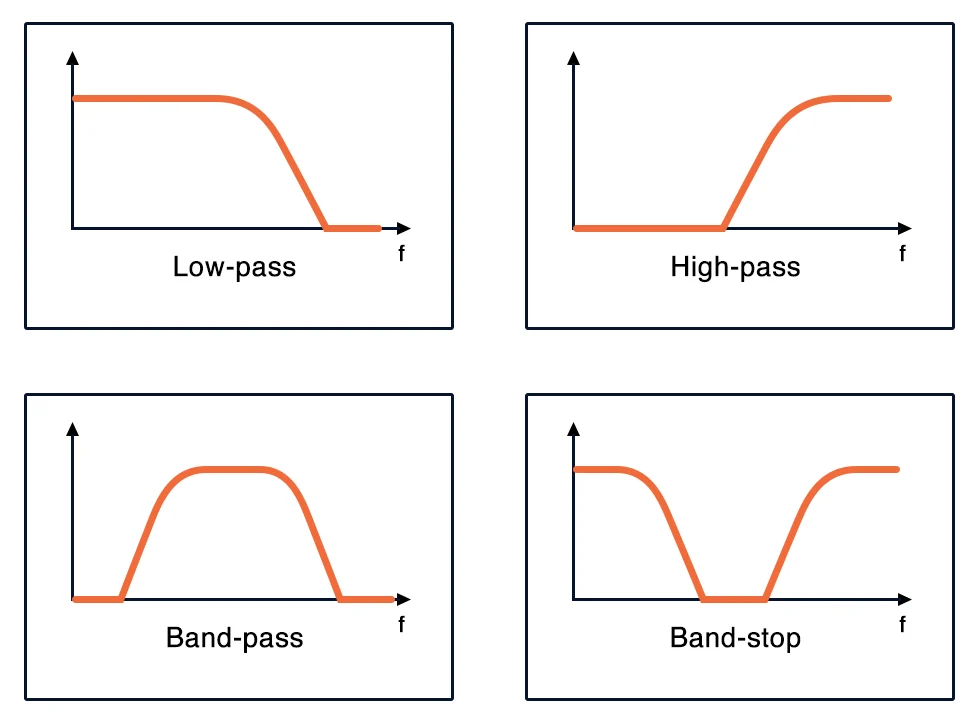

The thing about filters is that they're not that binary (pass or not pass), they're generally more like "muffling frequencies more and more from this frequency on". So they can have different profiles on how this "more and more" behaves, generating topologies for filters, like [Butterworth](https://en.wikipedia.org/wiki/Butterworth_filter) or [Chebyshev](https://en.wikipedia.org/wiki/Chebyshev_filter). 

For robotics, for a majority of things, a low-pass is just enough, specially for sensor signals. A lot of sensors are noisy, and most of the noise are high-frequency, so just getting them through a low-pass will smooth it. If you want to accentuate the "changes" on a signal, put them through high-pass. The image below illustrates a low-pass getting the "average" of the signal.

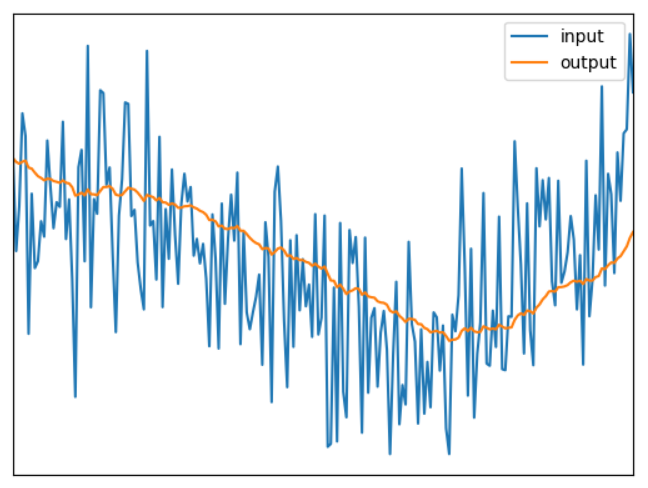

From this idea, it's also intuitive to see that integrals act as low-pass filters and derivatives act as high-pass filters.

---

## Digital Low-Pass Filter

The first order low-pass filter transfer function usually looks like this on the complex frequency domain:

$$
\frac{Y(s)}{X(s)} = \frac{\omega_c}{s + \omega_c}
$$

Where $Y$ is the output, $X$ is the input, and $\omega_c$ is the cutoff frequency of the filter (where it will start to atennuating higher frequencies). Taking the inverse Laplace transform on this, you get the differential equation that governs this system:

$$
\frac{1}{\omega_c} \cdot \frac{dy(t)}{dt} + y(t) = x(t)
$$

For convenience, let $\frac{1}{\omega_c} = \tau$. To move that to a discrete scenario, where it can be implemented digitally, it's intuitive to use the *Forward Euler Method*, where we explicitly define a derivative as a difference between samples (referencing it's own definition), like so:

$$
\frac{dy(t)}{dt} \approx \frac{y[k] - y[k-1]}{T_s}
$$

Where $T_s$ is the sampling period. Bringing the differential equation to discrete time, we get:

$$
\tau \left(\frac{y[k] - y[k-1]}{T_s} \right) + y[k] = x[k]
$$

Then solving for $y[k]$:

$$
y[k] = \frac{T}{\tau + T} x[k] + \frac{\tau}{\tau + T} y[k-1]
$$

Now define:

$$
\alpha = \frac{T}{\tau + T}
$$

Then:

$$
y[k] = \alpha x[k] + (1 - \alpha) y[k-1]
$$

As its shown, the output of the filter depends on the input and the last value of iself. In this case, we'll characterize this filter as **first order**, since the system it represents is characterized by a first order differential equation.

To make a higher order filter (that will essentially filter *more*), it's possible to just cascade the output of a first order filter into another first order filter $N$ times. 

$$
x_1[k] = x[k] \\
x_2[k] = y_1[k] \\
x_3[k] = y_2[k] \\
... \\
x_N[k] = y_{N-1}[k] \\
$$

This cascading configuration will result in an **Nth Order Low-Pass Filter**, although not optimal. 

---

## Digital High-Pass Filter

The first order high-pass filter transfer function usually looks like this on the complex frequency domain:

$$
\frac{Y(s)}{X(s)} = \frac{s}{s + \omega_c}
$$

Where $Y$ is the output, $X$ is the input, and $\omega_c$ is the cutoff frequency of the filter (where it will start to atennuating higher frequencies). Taking the inverse Laplace transform on this, you get the differential equation that governs this system:

$$
\frac{1}{\omega_c} \cdot \frac{dy(t)}{dt} + y(t) = \frac{dx(t)}{dt}
$$

For convenience, let $\frac{1}{\omega_c} = \tau$. Using *Forward Euler Method* to bring this differential equations to discrete time, where $T_s$ is the sampling period:

$$
\tau \left(\frac{y[k] - y[k-1]}{T_s} \right) + y[k] = \left(\frac{x[k] - x[k-1]}{T_s} \right)
$$

Solving for $y[k]$:

$$
y[k] = \alpha (y[k-1] + x[k] - x[k-1])
$$

Where:

$$
\alpha = \frac{\tau}{\tau + T}
$$

To make an **Nth Order High-Pass Filter**, the cascading method still applies.

---

## Digital Band-Pass and Band-Reject Filters

To achieve a rough Band-Pass and Band-Reject filters, it's possible to cascade a low-pass and a high-pass together, the order doesn't really matter much. Cascading an Nth order low-pass with an Nth order high-pass will produce an Nth order band-pass or band-reject. 

What really determines if the resulting filter is going to be a band-pass or band-reject is the following relationship between the cutoff frequencies of the low-pass $\omega_{lp}$ and high-pass $\omega_{hp}$ filters:

$$
\begin{cases}
\omega_{hp} < \omega_{lp} \text{  , for a Band-Pass} \\ \\
\omega_{lp} < \omega_{hp} \text{  , for a Band-Reject}
\end{cases}
$$

---

In [208]:
# Importing modules...
import numpy as np

import sys
sys.path.append('..') # Go back to base directory

from modules.graph import *
from modules.viewer3d import *

In [209]:
class FirstOrderLowPass:
    def __init__(
        self, 
        fc, # Cutoff frequency, in Hz
        fs, # Sampling frequency, in Hz
    ):
        self.Ts = 1.0 / fs # Sampling time
        self.tau = 1.0 / (2 * np.pi * fc) # Filter time constant
        self.alpha = self.Ts / (self.tau + self.Ts)
        self.y_prev = 0.0

    def filter(self, x):
        y = self.alpha * x + (1 - self.alpha) * self.y_prev
        self.y_prev = y

        return y
    
class LowPassFilter:
    def __init__(
        self, 
        order, # Order of the filter
        fc,    # Cutoff frequency, in Hz
        fs     # Sampling frequency, in Hz
    ):
        self.stages = [FirstOrderLowPass(fc, fs) for _ in range(order)]

    def filter(self, x):
        for stage in self.stages:
            x = stage.filter(x)
            
        return x

In [210]:
class FirstOrderHighPass:
    def __init__(
        self, 
        fc, # Cutoff frequency, in Hz
        fs, # Sampling frequency, in Hz
    ):
        self.Ts = 1.0 / fs # Sampling time
        self.tau = 1.0 / (2 * np.pi * fc) # Filter time constant
        self.alpha = self.tau / (self.tau + self.Ts)
        self.x_prev = 0.0
        self.y_prev = 0.0

    def filter(self, x):
        y = self.alpha * (self.y_prev + x - self.x_prev)
        self.x_prev = x
        self.y_prev = y
        return y
    
class HighPassFilter:
    def __init__(
        self, 
        order, # Order of the filter
        fc,    # Cutoff frequency, in Hz
        fs     # Sampling frequency, in Hz
    ):
        self.stages = [FirstOrderHighPass(fc, fs) for _ in range(order)]

    def filter(self, x):
        for stage in self.stages:
            x = stage.filter(x)
            
        return x

In [211]:
# Simulation time parameters
fs = 1e4
start_time = 0.0 # In Seconds
stop_time = 5.0  # In Seconds

time_vector = np.linspace(
    start_time, 
    stop_time, 
    int((stop_time - start_time) * fs)
)

# 1st Order Low-Pass
LPF = LowPassFilter(
    order=1,
    fc=0.5,
    fs=fs
)

# 1st Order High-Pass
HPF = HighPassFilter(
    order=1,
    fc=0.5,
    fs=fs
)

# Generating step function
input_signal = np.heaviside(time_vector - 1.0, 1)

# Filtering step function
lpf_output_signal = np.array([LPF.filter(sample) for sample in input_signal])

# Filtering step function
hpf_output_signal = np.array([HPF.filter(sample) for sample in input_signal])

In [212]:
# Plot input variables
graph = Graph(
    title="Low-Pass Filter Step Response", 
    axis_title=("Time (s)", "Input")
)

graph.add_trace(
    points=np.vstack((time_vector, input_signal)), 
    name="Input"
)

graph.add_trace(
    points=np.vstack((time_vector, lpf_output_signal)), 
    name="Low-Pass Output"
)

graph.figure.show(renderer='notebook_connected')

In [213]:
# Plot input variables
graph = Graph(
    title="High-Pass Filter Step Response", 
    axis_title=("Time (s)", "Input")
)

graph.add_trace(
    points=np.vstack((time_vector, input_signal)), 
    name="Input"
)

graph.add_trace(
    points=np.vstack((time_vector, hpf_output_signal)), 
    name="High-Pass Output"
)

graph.figure.show(renderer='notebook_connected')

In [214]:
# Simulation time parameters
fs = 1e4
start_time = 0.0 # In Seconds
stop_time = 2.0  # In Seconds

f_low = 2 # In Hz
f_high = 20 # In Hz

time_vector = np.linspace(
    start_time, 
    stop_time, 
    int((stop_time - start_time) * fs)
)

# 5th Order Low-Pass
LPF = LowPassFilter(
    order=5,
    fc=(f_low + f_high)/2,
    fs=fs
)

# 5th Order High-Pass
HPF = HighPassFilter(
    order=5,
    fc=(f_low + f_high)/2,
    fs=fs
)

# Generating mixed sine function
input_signal = np.sin(f_low * (2*np.pi) * time_vector) + 0.1 * np.sin(f_high * (2*np.pi) * time_vector)

# Filtering step function
lpf_output_signal = np.array([LPF.filter(sample) for sample in input_signal])

# Filtering step function
hpf_output_signal = np.array([HPF.filter(sample) for sample in input_signal])

In [215]:
# Plot input variables
graph = Graph(
    title="Separating Signals", 
    axis_title=("Time (s)", "Input")
)

graph.add_trace(
    points=np.vstack((time_vector, input_signal)), 
    name="Input"
)

graph.add_trace(
    points=np.vstack((time_vector, lpf_output_signal)), 
    name="Low-Pass Output"
)

graph.add_trace(
    points=np.vstack((time_vector, hpf_output_signal)), 
    name="High-Pass Output"
)

graph.figure.show(renderer='notebook_connected')